# December, 19th 2020

**Motivation**: Find out if certain types of responses are overrepresented in some trials vs others.<br>
**Result**: No, the label of a single trajectory is not really predictive of its nearest neighbor.  Yet another evidence that individual responses are mixed.

In [1]:
# HIDE CODE

import os
import sys
import h5py
import pickle
import numpy as np
import pandas as pd
from os.path import join as pjoin
from copy import deepcopy as dc
from tqdm.notebook import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

github_path = pjoin(os.environ['HOME'], 'Dropbox/git/A1ToneDiscrimination/')
sys.path.insert(0, github_path)
from utils.process import *
from utils.generic_utils import *
from utils.plot_functions import *

## Nearest Neighbor Analysis

In this section I use nearest neighbor analysis to check if there are some types of responses that occur more in certain trial types.  Steps:

1. take all calcium traces and make a **bag of trajectories**
2. draw a sample trajectory from this bag.  call it **source** trajectory
3. find its nearest neighbors (say 100).  call this set **NN(source)**
4. NN(source) has 100 trajectories and each of them has a label
5. Is the label for source, predictive of distribution of these 100 NN labels?

To measure this, I use mutual info between two random variables, one being source label call it $X$, and the other is $Y$ which stands for its nearest neighbor labels.  There are two possibilities:

- Maximum mutual info case: e.g. if source label = hit means all the other 100 labels will be also hit and so on
- Minimum mutual info case: if 100 NN labels are distributed just like the prior, and knowing source label doesn't tell us much

Here is the intuition.  From definition of mutual info we have:

$MI(X; Y) = \mathbb{E}_{x, y \sim P(X, Y)} \left[\log\frac{P(X, Y)}{P(X) P(Y)}\right]
 = \mathbb{E}_{x\sim P(X)} \left[D_{KL}\left( P(Y | X) || P(Y) \right)\right].$
 
A large KL divergence between $P(Y | X)$ and $P(Y)$ indicates that knowing $X$ (or the source label) is highly informative about what $Y$ (or the target label) is going to be. On the other hand, if the conditional distribution is not so different from the prior then there is not much shared information between these variables.

I will now use Python packages to find and visualize 100 NNs for a trajectory.

### Full trajectories

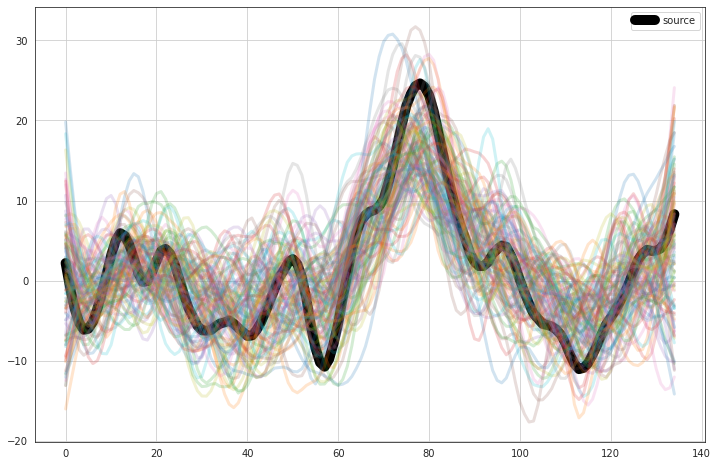

In [4]:
# HIDE CODE


from sklearn.neighbors import NearestNeighbors
dirs_dict = get_dirs()
output_trial, output_freq = bag_of_trajectories(dirs_dict['h_load_file'])

x = output_trial['dff']
df = output_trial['df']
labels = df.trial.to_numpy()


# NN fit
num_neighbors = 100
nn = NearestNeighbors(
    n_neighbors=num_neighbors+1,
    radius=0.4,
    n_jobs=-1,
).fit(x)

# connectivity matrix
distances = nn.kneighbors_graph(x)


# plot neighbors for a random sample
i = 1508
neighbor_indxs = distances[i].nonzero()[1]
neighbor_indxs = neighbor_indxs[neighbor_indxs != i]

plt.figure(figsize=(12, 8))
plt.plot(x[i], lw=10, color='k', label='source')
plt.plot(x[neighbor_indxs].T, lw=3, alpha=0.2)
plt.legend()
plt.grid()
plt.show()

#### Do neighbors have more or less the same label?

If yes, then there is information in each trace about trial types

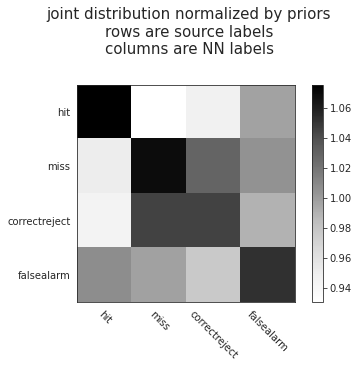

mi: 1.27e-03,  max mi: 1.19e+00


In [30]:
# HIDE CODE


l2i = output_trial['str2int']
i2l = output_trial['int2str']
trials = list(l2i.keys())
coocerances = {'{:s}-{:s}'.format(t1, t2): 0 for t1 in trials for t2 in trials}

for i in tqdm(range(len(x)), leave=False):
    t1 = labels[i]
    neighbor_indxs = distances[i].nonzero()[1]
    neighbor_indxs = neighbor_indxs[neighbor_indxs != i]
    for t2 in labels[neighbor_indxs]:
        key = '{:s}-{:s}'.format(t1, t2)
        coocerances[key] += 1

joint = np.zeros((len(trials), len(trials)))
for t1 in trials:
    for t2 in trials:
        key = '{:s}-{:s}'.format(t1, t2)
        joint[l2i[t1], l2i[t2]] = coocerances[key]
        
joint /= (num_neighbors * len(x))

p_x = joint.sum(1, keepdims=True) 
p_y = joint.sum(0, keepdims=True)
y_given_x = joint / p_x
x_given_y = joint / p_y

kl = y_given_x * np.log(y_given_x / p_y)
mi = p_x * y_given_x * np.log(y_given_x / p_y)
mi_max = p_x * np.eye(4) * np.log(np.eye(4) / p_y + 1e-12)

plt.imshow(joint / p_x / p_y, cmap='Greys')
plt.xticks(list(i2l.keys()), list(i2l.values()), rotation=-45)
plt.yticks(list(i2l.keys()), list(i2l.values()), rotation=0)
msg = 'joint distribution normalized by priors\nrows are source labels\ncolumns are NN labels'
plt.suptitle(msg, fontsize=15, y=1.15)
plt.colorbar()
plt.show()

print('mi: {:.2e},  max mi: {:.2e}'.format(mi.sum(), mi_max.sum()))

Observation: there is not much of shared structure in single cell traces as a function of trial label.  What if we used only the stimulus presentation period?

### Only stim period

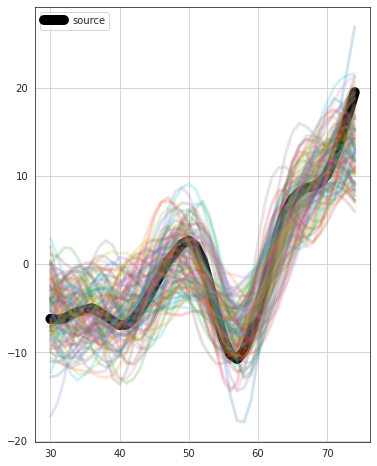

In [33]:
# HIDE CODE


trange = range(30, 75)
x = output_trial['dff'][:, trange]
df = output_trial['df']
labels = df.trial.to_numpy()


# NN fit
num_neighbors = 100
nn = NearestNeighbors(
    n_neighbors=num_neighbors+1,
    radius=0.4,
    n_jobs=-1,
).fit(x)

# connectivity matrix
distances = nn.kneighbors_graph(x)

# plot neighbors for a random sample
i = 1508
neighbor_indxs = distances[i].nonzero()[1]
neighbor_indxs = neighbor_indxs[neighbor_indxs != i]

plt.figure(figsize=(6, 8))
plt.plot(trange, x[i], lw=10, color='k', label='source')
plt.plot(trange, x[neighbor_indxs].T, lw=3, alpha=0.2)
plt.legend()
plt.grid()
plt.show()

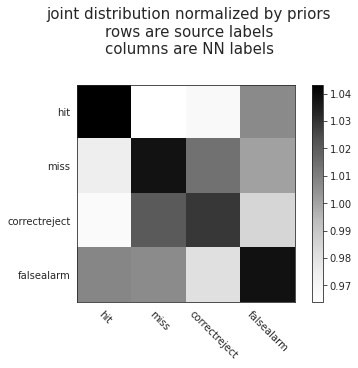

mi: 4.54e-04,  max mi: 1.19e+00


In [34]:
# HIDE CODE


coocerances = {'{:s}-{:s}'.format(t1, t2): 0 for t1 in trials for t2 in trials}

for i in tqdm(range(len(x)), leave=False):
    t1 = labels[i]
    neighbor_indxs = distances[i].nonzero()[1]
    neighbor_indxs = neighbor_indxs[neighbor_indxs != i]
    for t2 in labels[neighbor_indxs]:
        key = '{:s}-{:s}'.format(t1, t2)
        coocerances[key] += 1

joint = np.zeros((len(trials), len(trials)))
for t1 in trials:
    for t2 in trials:
        key = '{:s}-{:s}'.format(t1, t2)
        joint[l2i[t1], l2i[t2]] = coocerances[key]
        
joint /= (num_neighbors * len(x))

p_x = joint.sum(1, keepdims=True) 
p_y = joint.sum(0, keepdims=True)
y_given_x = joint / p_x
x_given_y = joint / p_y

kl = y_given_x * np.log(y_given_x / p_y)
mi = p_x * y_given_x * np.log(y_given_x / p_y)
mi_max = p_x * np.eye(4) * np.log(np.eye(4) / p_y + 1e-12)

plt.imshow(joint / p_x / p_y, cmap='Greys')
plt.xticks(list(i2l.keys()), list(i2l.values()), rotation=-45)
plt.yticks(list(i2l.keys()), list(i2l.values()), rotation=0)
msg = 'joint distribution normalized by priors\nrows are source labels\ncolumns are NN labels'
plt.suptitle(msg, fontsize=15, y=1.15)
plt.colorbar()
plt.show()

print('mi: {:.2e},  max mi: {:.2e}'.format(mi.sum(), mi_max.sum()))

Observation: mi almost zero, therefore $X$ and $Y$ are almost independent

## Target/Nontarget

What if we did the same analysis, but for stim frequency now?

### Full trajectories

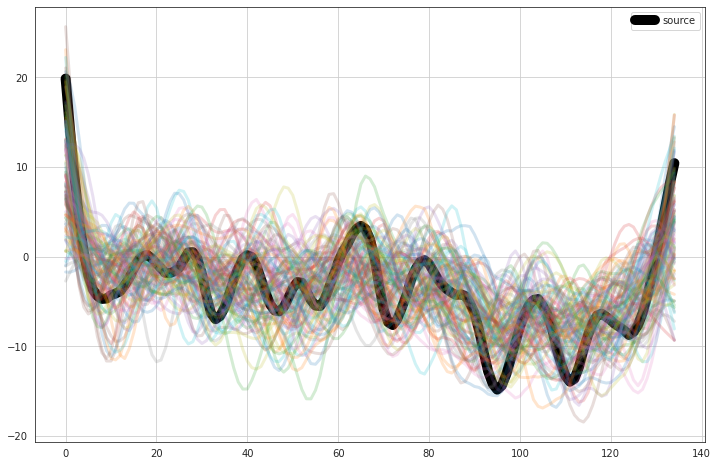

In [37]:
# HIDE CODE


x = output_freq['dff']
df = output_freq['df']
labels = df.freq.to_numpy()


# NN fit
num_neighbors = 100
nn = NearestNeighbors(
    n_neighbors=num_neighbors+1,
    radius=0.4,
    n_jobs=-1,
).fit(x)

# connectivity matrix
distances = nn.kneighbors_graph(x)


# plot neighbors for a random sample
i = 1508
neighbor_indxs = distances[i].nonzero()[1]
neighbor_indxs = neighbor_indxs[neighbor_indxs != i]

plt.figure(figsize=(12, 8))
plt.plot(x[i], lw=10, color='k', label='source')
plt.plot(x[neighbor_indxs].T, lw=3, alpha=0.2)
plt.legend()
plt.grid()
plt.show()

#### Do neighbors come more or less from the same trial type?

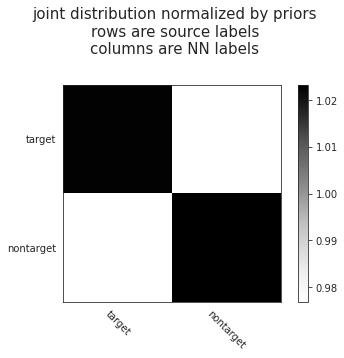

mi: 2.66e-04,  max mi: 6.93e-01


In [53]:
# HIDE CODE



c2i = {'target': 0, 'nontarget': 1}
i2c = {i: c for c, i in c2i.items()}
stim_classes = list(c2i.keys())
coocerances = {'{:s}-{:s}'.format(c1, c2): 0 for c1 in stim_classes for c2 in stim_classes}

for i in tqdm(range(len(x)), leave=False):
    c1 = labels[i]
    c1 = 'target' if c1 < 12000 else 'nontarget'
    neighbor_indxs = distances[i].nonzero()[1]
    neighbor_indxs = neighbor_indxs[neighbor_indxs != i]
    for c2 in labels[neighbor_indxs]:
        c2 = 'target' if c2 < 12000 else 'nontarget'
        key = '{:s}-{:s}'.format(c1, c2)
        coocerances[key] += 1

joint = np.zeros((len(stim_classes), len(stim_classes)))
for c1 in stim_classes:
    for c2 in stim_classes:
        key = '{:s}-{:s}'.format(c1, c2)
        joint[c2i[c1], c2i[c2]] = coocerances[key]
        
joint /= (num_neighbors * len(x))

p_x = joint.sum(1, keepdims=True) 
p_y = joint.sum(0, keepdims=True)
y_given_x = joint / p_x
x_given_y = joint / p_y

kl = y_given_x * np.log(y_given_x / p_y)
mi = p_x * y_given_x * np.log(y_given_x / p_y)
mi_max = p_x * np.eye(2) * np.log(np.eye(2) / p_y + 1e-12)

plt.imshow(joint / p_x / p_y, cmap='Greys')
plt.xticks(list(i2c.keys()), list(i2c.values()), rotation=-45)
plt.yticks(list(i2c.keys()), list(i2c.values()), rotation=0)
msg = 'joint distribution normalized by priors\nrows are source labels\ncolumns are NN labels'
plt.suptitle(msg, fontsize=15, y=1.15)
plt.colorbar()
plt.show()


print('mi: {:.2e},  max mi: {:.2e}'.format(mi.sum(), mi_max.sum()))

Observation: similar to trial type labels, mi is almost zero

## Discussion
### single cell trajectories are distributed arbitraryly, with respect to trial label, as well as stim frequency

These results reinforce the ones from yesterday.  We simply cannot take a trajectory from an individual cell and expect to find (linear) information in it about whether it comes from a hit trial or a miss trial; whether it comes form a target frequency or a nontarget frequency and so on.